# **Avaluació diferents algoritmes de Machine Learning**

## Objectiu

L'objectiu d'aquest scipts és l'anàlisi de diferents algoritmes de machine learning per tal de seleccionar el més prometedor de cara a classificar subjectes TEA o Control en funció de la segmentació de volums cerebrals



## **PAS1: importar llibreries**

In [1]:
!pip install xgboost
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00


In [2]:
# importar llibreries
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.optimizers import SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os

from catboost import CatBoostClassifier

## **PAS2: enllaçar amb drive**

In [3]:
from google.colab import drive
#montar drive
drive.mount('/content/drive')

Mounted at /content/drive


## **PAS3: llegir arxius**

In [4]:
#paths relatius a l'arxiu ipynb
import glob
# recuperar ruta de l0scritp
script_name = 'comparacio_ML.ipynb'
drive.mount(os.getcwd() + '/drive')
script_path = glob.glob(os.getcwd() + '/**/' + script_name, recursive = True)
print(script_path)
head_tail = os.path.split(script_path[0])
# guardem carpeta de treball
work_path = head_tail[0];


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/TFM/P4/comparacio_ML.ipynb']


In [5]:
#llegir CSV
v_path = work_path + '/CSV/harmonized_data.csv'

# Lectura arxiu
vol = pd.read_csv(v_path, encoding='latin-1')

In [6]:
print("El conjunt de dades conté informació de " + str(vol.shape[0]) + " persones diferents i " + str(vol.shape[1]) + " variables.")

El conjunt de dades conté informació de 316 persones diferents i 39 variables.


In [7]:
# no sé si afegir el "total intracranial" del dataset vol_ICV
vol.head()

,Unnamed: 0,left cerebral white matter,left cerebral cortex,left lateral ventricle,left inferior lateral ventricle,left cerebellum white matter,left cerebellum cortex,left thalamus,left caudate,left putamen,...,right hippocampus,right amygdala,right accumbens area,right ventral DC,SITE,SUB_ID,DX_GROUP,AGE_AT_SCAN,SEX,FIQ
0,0,0.148201,0.172916,0.004299,0.000391,0.008866,0.029530,0.004925,0.003081,0.004373,...,0.002594,0.001163,0.000535,0.002639,ABIDEII-BNI_1,29028,TEA,21.0,1,94.0
1,1,0.143959,0.177085,0.004137,0.000384,0.009878,0.034666,0.005442,0.002604,0.004202,...,0.003006,0.001243,0.000511,0.002759,ABIDEII-BNI_1,29029,TEA,20.0,1,97.0
2,2,0.135129,0.166210,0.005572,0.000428,0.011263,0.037202,0.004642,0.003030,0.003988,...,0.002713,0.001262,0.000484,0.002822,ABIDEII-BNI_1,29030,TEA,18.0,1,111.0
3,3,0.149008,0.166349,0.006931,0.000424,0.012182,0.037870,0.005128,0.002787,0.003658,...,0.002787,0.001200,0.000442,0.002929,ABIDEII-BNI_1,29031,TEA,21.0,1,97.0
4,4,0.142604,0.162814,0.009000,0.000391,0.010841,0.032813,0.004516,0.002994,0.003793,...,0.003066,0.001127,0.000441,0.002720,ABIDEII-BNI_1,29037,TEA,19.0,1,139.0


In [8]:
# path imatges
img_path = work_path + '/graphs/'
# crear carpeta si no existeix
if not os.path.exists(img_path):
    os.makedirs(img_path)

## PAS4: Preparació Dades

Eliminar columnes unnamed, SITE i SUB_ID

In [9]:
# data frame
vol.drop(vol.columns[vol.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
vol.drop(['SITE','SUB_ID','FIQ'], axis=1, inplace=True)
vol.columns

Index(['left cerebral white matter', 'left cerebral cortex',
       'left lateral ventricle', 'left inferior lateral ventricle',
       'left cerebellum white matter', 'left cerebellum cortex',
       'left thalamus', 'left caudate', 'left putamen', 'left pallidum',
       '3rd ventricle', '4th ventricle', 'brain-stem', 'left hippocampus',
       'left amygdala', 'csf', 'left accumbens area', 'left ventral DC',
       'right cerebral white matter', 'right cerebral cortex',
       'right lateral ventricle', 'right inferior lateral ventricle',
       'right cerebellum white matter', 'right cerebellum cortex',
       'right thalamus', 'right caudate', 'right putamen', 'right pallidum',
       'right hippocampus', 'right amygdala', 'right accumbens area',
       'right ventral DC', 'DX_GROUP', 'AGE_AT_SCAN', 'SEX'],
      dtype='object')

In [10]:
# copio les dades en un dataset de treball
df_to_test = vol.copy(True)

x = df_to_test.drop(['DX_GROUP'], axis=1)
y = df_to_test['DX_GROUP']

brain-stem                          0.041819
left caudate                        0.040236
3rd ventricle                       0.039207
right cerebral white matter         0.037743
left cerebral white matter          0.037604
4th ventricle                       0.036069
right pallidum                      0.035753
right accumbens area                0.034601
right ventral DC                    0.032711
right lateral ventricle             0.032692
left putamen                        0.032535
left cerebellum white matter        0.032407
left amygdala                       0.032218
AGE_AT_SCAN                         0.031692
right cerebellum white matter       0.031590
left thalamus                       0.031327
left ventral DC                     0.030725
left cerebral cortex                0.028920
left lateral ventricle              0.027952
left inferior lateral ventricle     0.027785
right thalamus                      0.027543
right putamen                       0.026933
left hippo

/tmp/ipython-input-2932027947.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(importances,palette='Spectral')


Text(0.5, 1.0, 'Importància regions')

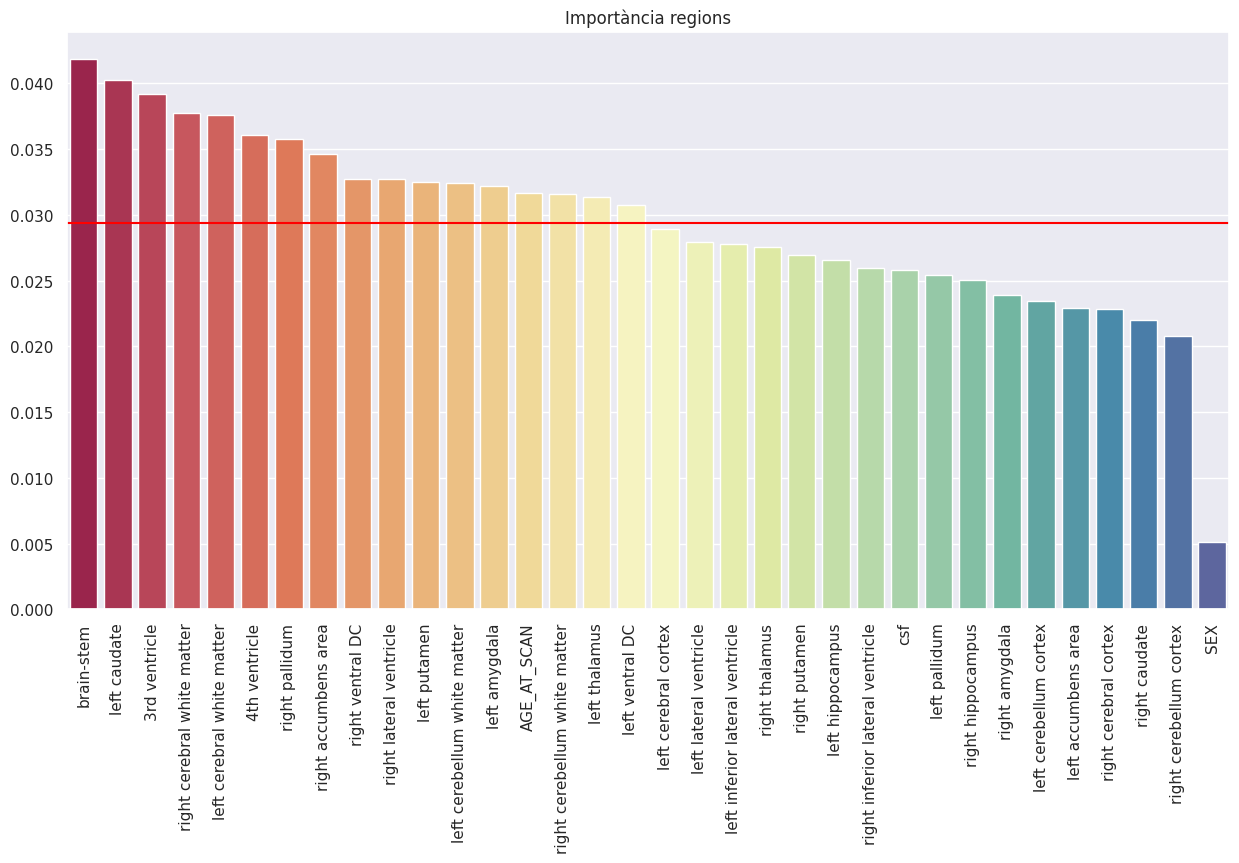

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Entrenar Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Importància de les regions
importances = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)
top10 = importances
print(top10)

fig, axis = plt.subplots(figsize = (15,7.5))
plot = sns.barplot(importances,palette='Spectral')
plot.axhline(importances.mean(), color='red')
plot.set_xticks(np.arange(len(importances)))
plot.set_xticklabels(plot.get_xticklabels(),rotation = 90)
plot.set_title("Importància regions")

In [12]:
# seleccionar les regions que tenen una importància >= mitjana
mean_val = importances.mean()
# inicial
regions_select = importances[importances > mean_val-0.0005].index
print(regions_select)

Index(['brain-stem', 'left caudate', '3rd ventricle',
       'right cerebral white matter', 'left cerebral white matter',
       '4th ventricle', 'right pallidum', 'right accumbens area',
       'right ventral DC', 'right lateral ventricle', 'left putamen',
       'left cerebellum white matter', 'left amygdala', 'AGE_AT_SCAN',
       'right cerebellum white matter', 'left thalamus', 'left ventral DC',
       'left cerebral cortex'],
      dtype='object')


In [13]:
# reduir dataset a variables amb més importància
x = x[regions_select]

In [14]:
print("x shape: " + str(x.shape))
print("y shape: " + str(y.shape))

x shape: (316, 18)
y shape: (316,)


In [15]:
freq_table = pd.crosstab(y, "Distribució subjectes")
freq_table

col_0,Distribució subjectes
DX_GROUP,
CONTROL,156
TEA,160


## PAS5: Escalat de les dades

In [16]:
scaler = StandardScaler().set_output(transform="pandas")
x_scaled = scaler.fit_transform(x)

print("Esperem obtenir una mitjana de 0 i una desviació estándard de 1\r\n")
print("Comprobació dels resultats obtinguts:\r\n")
print("Mitjana = " + str(np.mean(x_scaled)) + "\r\nDesviacións estàndard: \r\n" + str(np.std(x_scaled)))
print()

Esperem obtenir una mitjana de 0 i una desviació estándard de 1

Comprobació dels resultats obtinguts:

Mitjana = -4.1504540076704165e-16
Desviacións estàndard: 
brain-stem                       1.0
left caudate                     1.0
3rd ventricle                    1.0
right cerebral white matter      1.0
left cerebral white matter       1.0
4th ventricle                    1.0
right pallidum                   1.0
right accumbens area             1.0
right ventral DC                 1.0
right lateral ventricle          1.0
left putamen                     1.0
left cerebellum white matter     1.0
left amygdala                    1.0
AGE_AT_SCAN                      1.0
right cerebellum white matter    1.0
left thalamus                    1.0
left ventral DC                  1.0
left cerebral cortex             1.0
dtype: float64



/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [17]:
# resum estadístic
x.describe()

,brain-stem,left caudate,3rd ventricle,right cerebral white matter,left cerebral white matter,4th ventricle,right pallidum,right accumbens area,right ventral DC,right lateral ventricle,left putamen,left cerebellum white matter,left amygdala,AGE_AT_SCAN,right cerebellum white matter,left thalamus,left ventral DC,left cerebral cortex
count,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000
mean,0.013127,0.002762,0.000472,0.146373,0.146075,0.001307,0.001093,0.000453,0.002721,0.004561,0.003824,0.010727,0.001152,18.645470,0.010661,0.004959,0.002710,0.169274
std,0.000974,0.000257,0.000129,0.005254,0.005217,0.000341,0.000085,0.000043,0.000168,0.001679,0.000280,0.000858,0.000086,5.816100,0.000850,0.000336,0.000167,0.006783
min,0.009614,0.002161,0.000264,0.132991,0.131859,0.000520,0.000883,0.000293,0.002217,0.002034,0.003020,0.008189,0.000739,8.000000,0.008214,0.003949,0.002273,0.150763
25%,0.012370,0.002596,0.000382,0.143081,0.142595,0.001075,0.001038,0.000424,0.002603,0.003303,0.003644,0.010138,0.001098,14.000000,0.010108,0.004714,0.002594,0.164485
50%,0.013124,0.002767,0.000446,0.146416,0.145962,0.001278,0.001086,0.000450,0.002714,0.004263,0.003813,0.010710,0.001155,18.030000,0.010621,0.004944,0.002693,0.168546
75%,0.013790,0.002942,0.000530,0.149963,0.149344,0.001512,0.001154,0.000480,0.002832,0.005577,0.004006,0.011265,0.001207,22.556667,0.011239,0.005199,0.002831,0.174331
max,0.015439,0.003539,0.001088,0.161364,0.160278,0.002668,0.001375,0.000585,0.003212,0.011978,0.004597,0.013078,0.001502,35.000000,0.012875,0.005963,0.003213,0.188752


# PCA

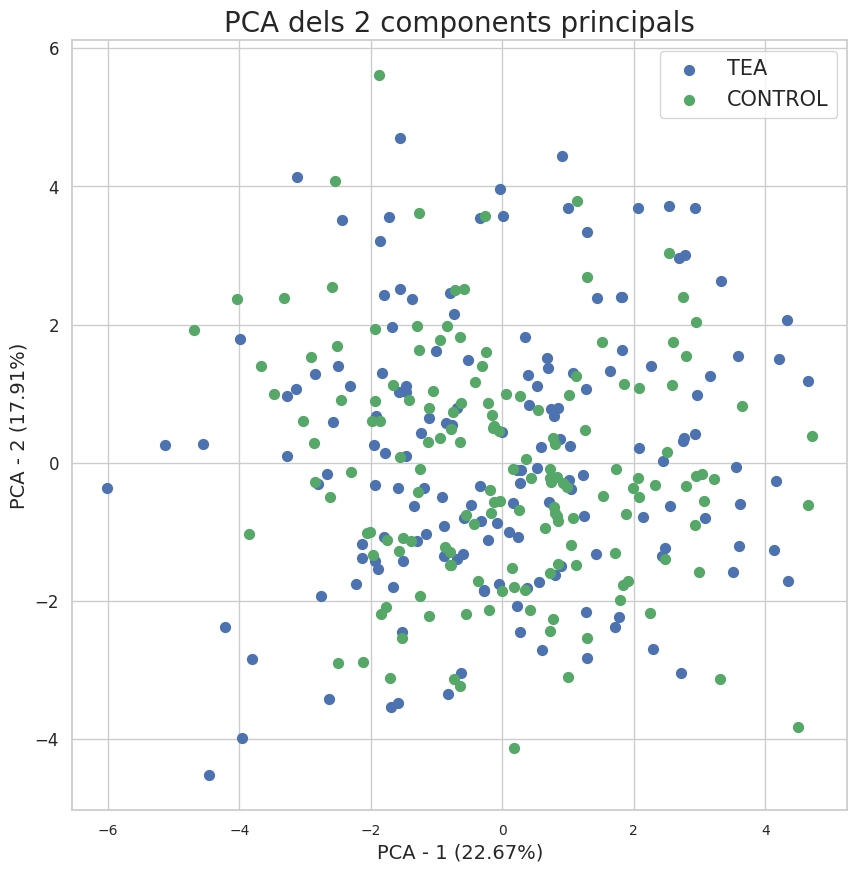

In [18]:
# busca els index on el tumor és benigne o maligne
indexTEA = [i for i, x in enumerate(y) if str(x) == 'TEA']
indexCTRL = [i for i, x in enumerate(y) if str(x) == 'CONTROL']

x_TEA = x_scaled.loc[indexTEA,]
x_CTRL = x_scaled.loc[indexCTRL,]

# gràficament
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
pca = PCA(n_components=2)
components_pca = pca.fit_transform(x_scaled)

plt.xlabel(f'PCA - 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)',fontsize=14)
plt.ylabel(f'PCA - 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)',fontsize=14)
plt.title("PCA dels 2 components principals",fontsize=20)
targets = ['TEA', 'CONTROL']
colors = ['b', 'g']
indexs = [indexTEA, indexCTRL]
for target, color in zip(targets,colors):
    indicesToKeep = [i for i, x in enumerate(y) if str(x) == target]
    plt.scatter(components_pca[indicesToKeep, 0],
                components_pca[indicesToKeep,1], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

No hi ha diferenciació entre els dos grups

# Dades d'entrenament i test

In [19]:
seed = 2025
test_size = 0.33
train_size = 0.67
msg = "Per separar les dades d'entrenament i test es fa servir la llavor = " +  str(seed) + ", un " + str(train_size*100) +  "% de les dades per a l'entrenament i un " + str(test_size*100) + "% per a la verificació"
print(msg)
# separació de les dades d'entrenament i test
xtrain, xtest, ytrain, ytest = train_test_split(x_scaled, y, test_size=test_size, random_state=seed)

Per separar les dades d'entrenament i test es fa servir la llavor = 2025, un 67.0% de les dades per a l'entrenament i un 33.0% per a la verificació


Estructura de les dades:

In [20]:
print('xtrain shape: ', xtrain.shape)
print('ytrain shape: ', ytrain.shape)
print('xtest shape: ', xtest.shape)
print('ytest shape: ', ytest.shape)

xtrain shape:  (211, 18)
ytrain shape:  (211,)
xtest shape:  (105, 18)
ytest shape:  (105,)


# Algoritmes de classificació

## k-Nearest Neighbour

Exploració amb els nombre de veïns *k*=1,3,5,7,11

In [21]:
# creació dels models pels diferents valors de k
ks = [1,3,5,7,11]
models_KNN = []
prediccions_KNN = []

for k in ks:
    model = KNeighborsClassifier(n_neighbors=k)
    # entrenament
    model.fit(xtrain, ytrain)
    # predicció
    pred = model.predict(xtest)
    models_KNN.append(model)
    prediccions_KNN.append(pred)

Matrius de confusió:

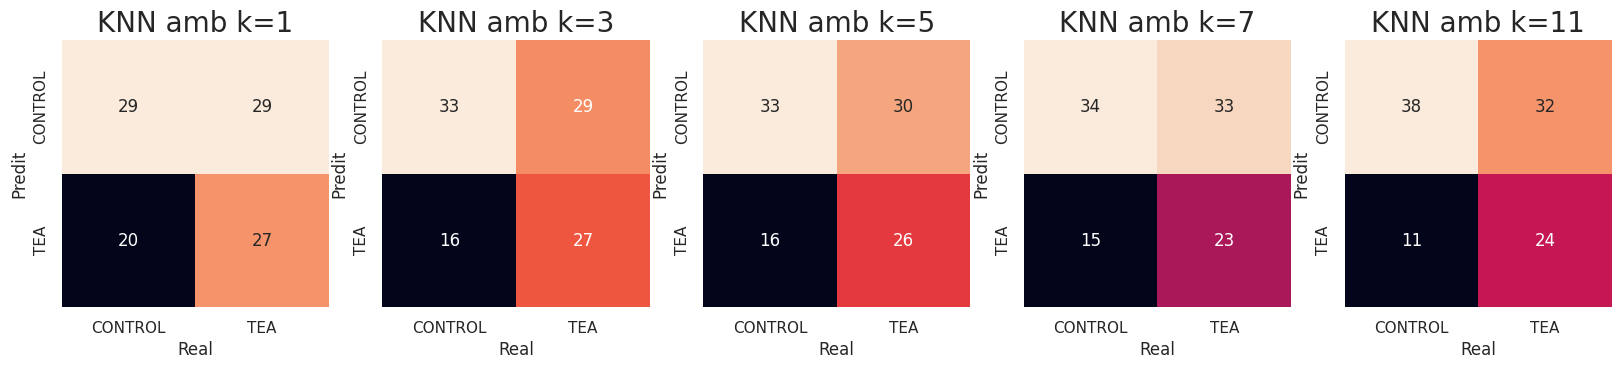

In [22]:
# Plot Confusion Matrix
i = 0
matrius_KNN = []
noms_mat_KNN = []
plt.figure(figsize=(20, 20))
for k in ks:
    mat = confusion_matrix(prediccions_KNN[i], ytest)
    names= np.unique(prediccions_KNN[i])

    plt.subplot(1, 5, i+1)
    plt.title("KNN amb k=" + str(k),fontsize=20)
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=names, yticklabels=names)
    plt.xlabel('Real')
    plt.ylabel('Predit')

    # guardem els resultats per més endavant
    matrius_KNN.append(mat)
    noms_mat_KNN.append(names)

    i += 1

Guardar resultats:

In [23]:
report_class_KNN = []
i = 0
for k in ks:
    report = classification_report(ytest, prediccions_KNN[i])
    i += 1
    report_class_KNN.append(report)
    print (report)

              precision    recall  f1-score   support

     CONTROL       0.50      0.59      0.54        49
         TEA       0.57      0.48      0.52        56

    accuracy                           0.53       105
   macro avg       0.54      0.54      0.53       105
weighted avg       0.54      0.53      0.53       105

              precision    recall  f1-score   support

     CONTROL       0.53      0.67      0.59        49
         TEA       0.63      0.48      0.55        56

    accuracy                           0.57       105
   macro avg       0.58      0.58      0.57       105
weighted avg       0.58      0.57      0.57       105

              precision    recall  f1-score   support

     CONTROL       0.52      0.67      0.59        49
         TEA       0.62      0.46      0.53        56

    accuracy                           0.56       105
   macro avg       0.57      0.57      0.56       105
weighted avg       0.57      0.56      0.56       105

              preci

# Naive Bayes

Totes les dades que tenim són numèriques i estant normalitzades, segueixen una distribució gaussiana, no fa falta activar **laplace**, són distribucions contínues i no tindrem el problema de probabilitat zero

In [24]:
model_NaiveBayes = GaussianNB()
# entrenament
model_NaiveBayes.fit(xtrain, ytrain)
# predicció
pred_NaiveBayes = model_NaiveBayes.predict(xtest)

Matriu de confusió:

Text(29.999999999999993, 0.5, 'Predit')

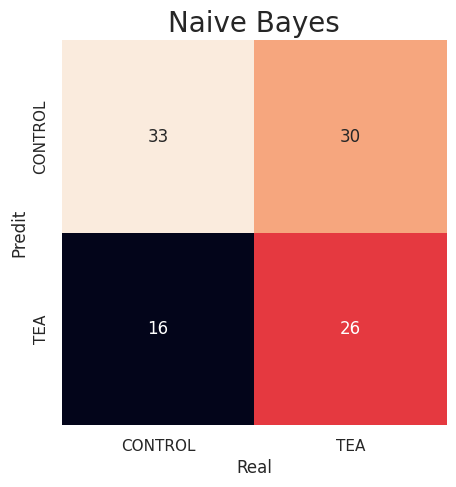

In [25]:
mat_NaiveBayes = confusion_matrix(pred_NaiveBayes, ytest)
names_NaiveBayes = np.unique(pred_NaiveBayes)

plt.figure(figsize=(5, 5))
plt.title("Naive Bayes",fontsize=20)
sns.heatmap(mat_NaiveBayes, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_NaiveBayes, yticklabels=names_NaiveBayes)
plt.xlabel('Real')
plt.ylabel('Predit')

Report:

In [26]:
report_NaiveBayes = classification_report(ytest, pred_NaiveBayes)
print(report_NaiveBayes)

              precision    recall  f1-score   support

     CONTROL       0.52      0.67      0.59        49
         TEA       0.62      0.46      0.53        56

    accuracy                           0.56       105
   macro avg       0.57      0.57      0.56       105
weighted avg       0.57      0.56      0.56       105



# Artificial Neural Network

Arquitectures amb 1 o 2 capes amagades

1- Amb 30 nodes en una capa oculta

2- 50 i 10 nodes en cada capa oculta

## Preparar dades

In [27]:
# guardem el número de variables i el número de resultats possibles
num_vars = xtrain.shape[1]
num_classes = ytrain.unique().size
print("Número de variables: " + str(num_vars))
print("Número de resultats possibles: " + str(num_classes))

Número de variables: 18
Número de resultats possibles: 2


In [28]:
# convertir categories a números (TEA a 0 i CONTROL a 1)
ytrain_np = ytrain.map({"TEA": 0, "CONTROL": 1}).to_numpy()
ytest_np = ytest.map({"TEA": 0, "CONTROL": 1}).to_numpy()

In [29]:
# convertir dades a Tensor per entrenar el model
# dades train
x_tensor_train = tf.convert_to_tensor(xtrain, dtype=float, name='x_tensor_train')
y_tensor_train = tf.convert_to_tensor(ytrain_np, dtype=float, name='y_tensor_train')
# dades test
x_tensor_test = tf.convert_to_tensor(xtest, dtype=float, name='x_tensor_test')
y_tensor_test = tf.convert_to_tensor(ytest_np, dtype=float, name='y_tensor_test')

### Neural Network amb 1 capa oculta i 30 nodes

In [30]:
# num nodes
n = 30
# inicialització model
model_NN_1_H_Layer = Sequential()
# capa amagada de 30 nodes
model_NN_1_H_Layer.add(Dense(n, input_dim = num_vars, activation='relu'))
model_NN_1_H_Layer.add(Dropout(0.3))
# capa de sortida amb els estats possibles
model_NN_1_H_Layer.add(Dense(1, activation='sigmoid'))

#summary del model
model_NN_1_H_Layer.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 601 (2.35 KB)

 Trainable params: 601 (2.35 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# definir funció de loss "Sparse Categorical Crossentropy", tenim 2 possibles
# classificacions i les dades estant convertides a enters
loss_function = keras.losses.BinaryCrossentropy(from_logits=True)
# compilar model
model_NN_1_H_Layer.compile(loss=loss_function, optimizer='adam',metrics=['accuracy'])

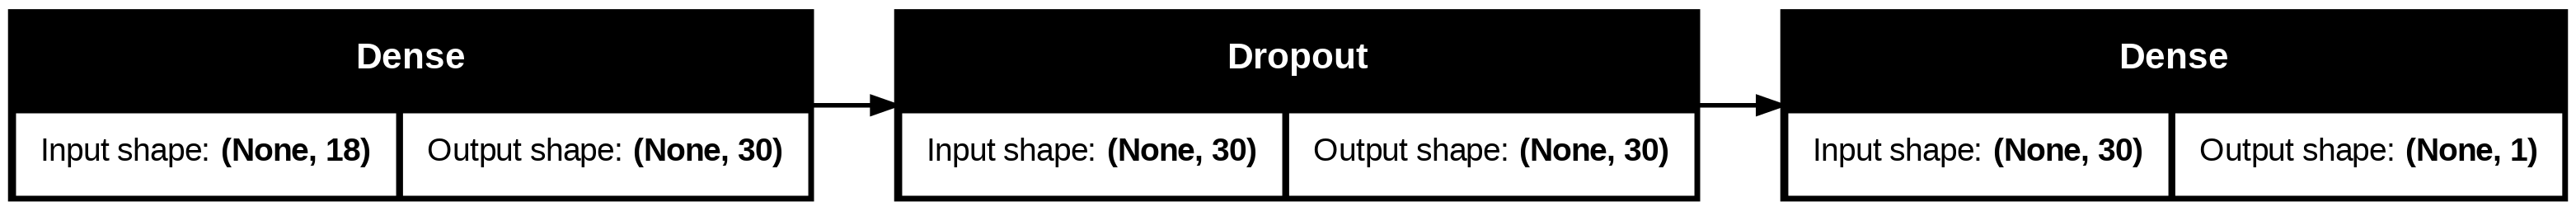

In [32]:
# connectivitat entre capes
keras.utils.plot_model(model_NN_1_H_Layer, show_shapes=True, rankdir="LR")

Entrenar model:

In [33]:
# entrenar el model amb un 20% de validació i 100 epochs
history_NN_1_H_Layer = model_NN_1_H_Layer.fit(x_tensor_train, y_tensor_train, batch_size=10, validation_split=0.2, epochs=100, verbose=False)

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Gràfics d'aprenentatge

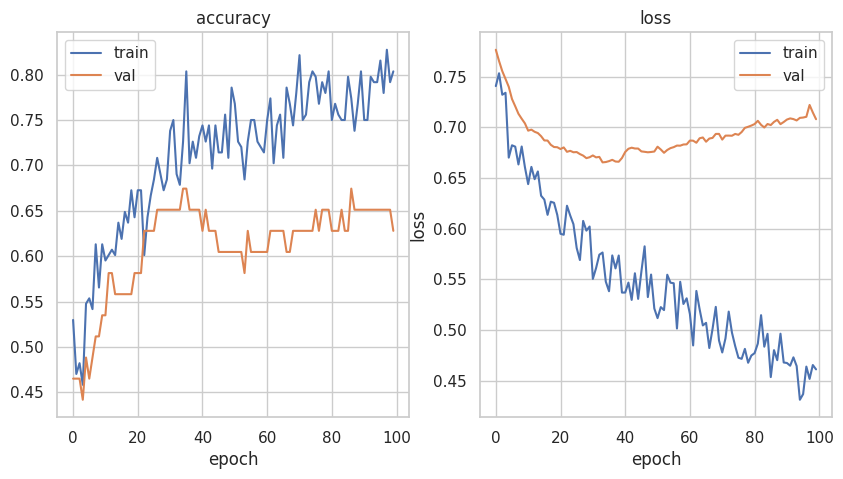

In [34]:
# plot training history
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_NN_1_H_Layer.history['accuracy'], label='train')
plt.plot(history_NN_1_H_Layer.history['val_accuracy'], label='val')
plt.title('accuracy')
plt.xlabel('epoch')
plt.legend()

# visualize loss
plt.subplot(1,2,2)
plt.plot(history_NN_1_H_Layer.history['loss'])
plt.plot(history_NN_1_H_Layer.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Predicció:

In [35]:
# Predicció
preds_NN_1_H_Layer = model_NN_1_H_Layer.predict(x_tensor_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Matriu de confusió:

Text(29.999999999999993, 0.5, 'Predit')

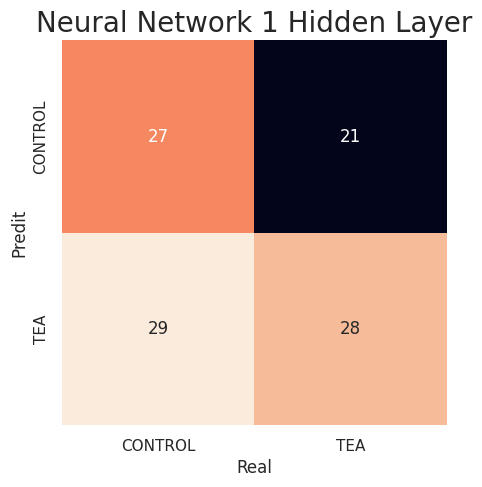

In [36]:
#convertir probabilitats a enters
#y_preds_NN_1_H_Layer = preds_NN_1_H_Layer.argmax(axis=1)

mat_NN_1_H_Layer = confusion_matrix(tf.round(preds_NN_1_H_Layer), y_tensor_test)
names_NN_1_H_Layer = np.unique(ytest)
plt.figure(figsize=(5, 5))
plt.title("Neural Network 1 Hidden Layer",fontsize=20)
sns.heatmap(mat_NN_1_H_Layer, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_NN_1_H_Layer, yticklabels=names_NN_1_H_Layer)
plt.xlabel('Real')
plt.ylabel('Predit')

N'encerta més que no en falla però no és fiable.

Report de classificació:

In [37]:
report_NN_1_H_Layer = classification_report(y_tensor_test, tf.round(preds_NN_1_H_Layer))
print(report_NN_1_H_Layer)

              precision    recall  f1-score   support

         0.0       0.56      0.48      0.52        56
         1.0       0.49      0.57      0.53        49

    accuracy                           0.52       105
   macro avg       0.53      0.53      0.52       105
weighted avg       0.53      0.52      0.52       105



### Neural Network amb 2 capes ocultes de 50 i 10 nodes

In [38]:
# num nodes
n1 = 32
n2 = 16
n3 = 8
# inicialització model
model_NN_2_H_Layer = Sequential()
# capa amagada 1 de 32 nodes
model_NN_2_H_Layer.add(Dense(n1, input_dim = num_vars, activation='relu'))
model_NN_2_H_Layer.add(Dropout(0.3))
# capa amagada 2 de 16 nodes
model_NN_2_H_Layer.add(Dense(n2, input_dim = num_vars, activation='relu'))
model_NN_2_H_Layer.add(Dropout(0.3))
# capa amagada 3 de 8 nodes
model_NN_2_H_Layer.add(Dense(n3, input_dim = num_vars, activation='relu'))
model_NN_2_H_Layer.add(Dropout(0.3))
# capa de sortida amb els estats possibles
model_NN_2_H_Layer.add(Dense(1, activation='sigmoid'))

#summary del model
model_NN_2_H_Layer.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 32)             │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# compilar model (amb la mateixa funció de loss que el model anterior)
model_NN_2_H_Layer.compile(loss=loss_function, optimizer='adam',metrics=['accuracy'])

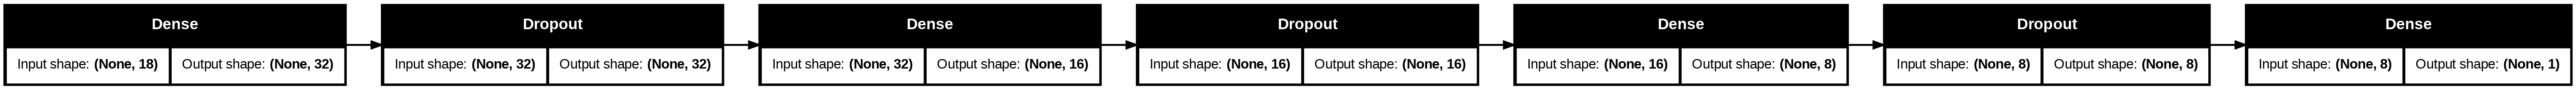

In [40]:
# connectivitat entre capes
keras.utils.plot_model(model_NN_2_H_Layer, show_shapes=True, rankdir="LR")

Entrenar model:

In [41]:
# entrenar el model amn un 20% de validació i 100 epochs
history_NN_2_H_Layer = model_NN_2_H_Layer.fit(x_tensor_train, y_tensor_train, batch_size=10, validation_split=0.2, epochs=100, verbose=False)

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


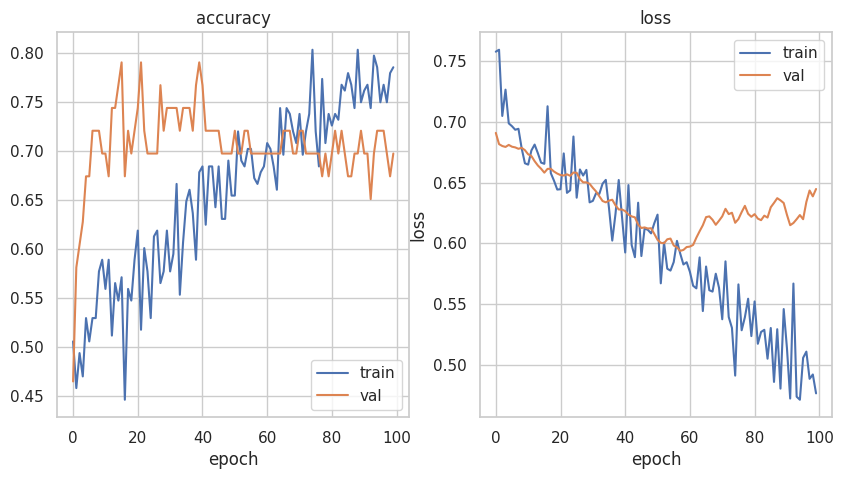

In [42]:
# plot training history
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_NN_2_H_Layer.history['accuracy'], label='train')
plt.plot(history_NN_2_H_Layer.history['val_accuracy'], label='val')
plt.title('accuracy')
plt.xlabel('epoch')
plt.legend()

# visualize loss
plt.subplot(1,2,2)
plt.plot(history_NN_2_H_Layer.history['loss'])
plt.plot(history_NN_2_H_Layer.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [43]:
# Predicció
preds_NN_2_H_Layer = model_NN_2_H_Layer.predict(x_tensor_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Text(29.999999999999993, 0.5, 'Predit')

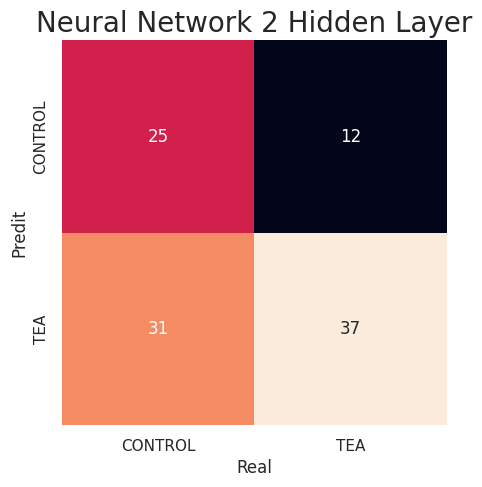

In [44]:
#convertir probabilitats a enters
#y_preds_NN_2_H_Layer = preds_NN_2_H_Layer.argmax(axis=1)

mat_NN_2_H_Layer = confusion_matrix(tf.round(preds_NN_2_H_Layer), y_tensor_test)
names_NN_2_H_Layer = np.unique(ytest)
plt.figure(figsize=(5, 5))
plt.title("Neural Network 2 Hidden Layer",fontsize=20)
sns.heatmap(mat_NN_2_H_Layer, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_NN_2_H_Layer, yticklabels=names_NN_2_H_Layer)
plt.xlabel('Real')
plt.ylabel('Predit')

In [45]:
report_NN_2_H_Layer = classification_report(y_tensor_test, tf.round(preds_NN_2_H_Layer))
print(report_NN_2_H_Layer)

              precision    recall  f1-score   support

         0.0       0.68      0.45      0.54        56
         1.0       0.54      0.76      0.63        49

    accuracy                           0.59       105
   macro avg       0.61      0.60      0.59       105
weighted avg       0.61      0.59      0.58       105



# Support Vector Machine

## SVM amb kernel lineal

In [46]:
#inicialització del classificador
model_SVM_Lineal = SVC(kernel='linear',random_state=seed)
# entrenament
model_SVM_Lineal.fit(xtrain,ytrain)
# predicció
pred_SVM_Lineal = model_SVM_Lineal.predict(xtest)

Text(29.999999999999993, 0.5, 'Predit')

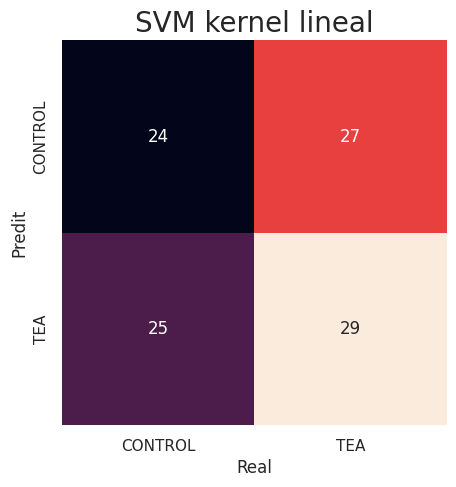

In [47]:
# Plot Confusion Matrix
mat_SVM_Lineal = confusion_matrix(pred_SVM_Lineal, ytest)
names_SVM_Lineal = np.unique(pred_SVM_Lineal)
plt.figure(figsize=(5, 5))
plt.title("SVM kernel lineal",fontsize=20)
sns.heatmap(mat_SVM_Lineal, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_SVM_Lineal, yticklabels=names_SVM_Lineal)
plt.xlabel('Real')
plt.ylabel('Predit')

In [48]:
report_SVM_Lineal = classification_report(ytest, pred_SVM_Lineal)
print(report_SVM_Lineal)

              precision    recall  f1-score   support

     CONTROL       0.47      0.49      0.48        49
         TEA       0.54      0.52      0.53        56

    accuracy                           0.50       105
   macro avg       0.50      0.50      0.50       105
weighted avg       0.51      0.50      0.51       105



## SVM amb kernel RBF

In [49]:
#inicialització del classificador
model_SVM_RBF = SVC(kernel='rbf',random_state=seed)
# entrenar
model_SVM_RBF.fit(xtrain,ytrain)
# predicció
pred_SVM_RBF = model_SVM_RBF.predict(xtest)

Text(29.999999999999993, 0.5, 'Predit')

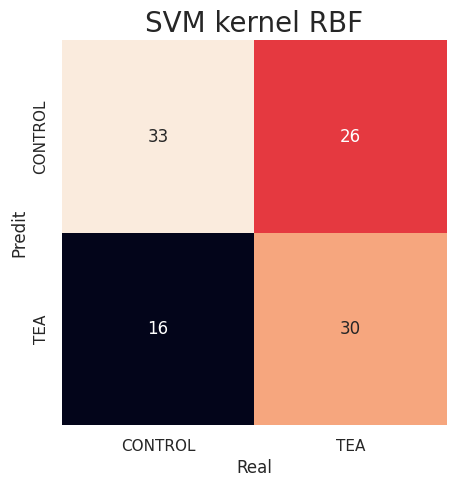

In [50]:
# Plot Confusion Matrix
mat_SVM_RBF = confusion_matrix(pred_SVM_RBF, ytest)
names_SVM_RBF = np.unique(pred_SVM_RBF)
plt.figure(figsize=(5, 5))
plt.title("SVM kernel RBF",fontsize=20)
sns.heatmap(mat_SVM_RBF, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_SVM_RBF, yticklabels=names_SVM_RBF)
plt.xlabel('Real')
plt.ylabel('Predit')

In [51]:
report_SVM_RBF = classification_report(ytest, pred_SVM_RBF)
print(report_SVM_RBF)

              precision    recall  f1-score   support

     CONTROL       0.56      0.67      0.61        49
         TEA       0.65      0.54      0.59        56

    accuracy                           0.60       105
   macro avg       0.61      0.60      0.60       105
weighted avg       0.61      0.60      0.60       105



## SVM Kernel rbf amb k-fold crossvalidation

In [52]:
from sklearn.model_selection import cross_val_score
k = 3
print ("Número de paquets en què es parteixen les dades d'entrenamet, k=" + str(k))
scores = cross_val_score(model_SVM_RBF,xtrain,ytrain,cv=k)


Número de paquets en què es parteixen les dades d'entrenamet, k=3


In [53]:
for i in range(k):
    print("k = %d , Pressició = %0.3f" % ((i+1),scores[i]))
print()
print("La precissió mitjana obtinguda és de %0.3f amb una desviació estandard de  %0.2f" % (scores.mean(), scores.std()))

k = 1 , Pressició = 0.563
k = 2 , Pressició = 0.557
k = 3 , Pressició = 0.600

La precissió mitjana obtinguda és de 0.574 amb una desviació estandard de  0.02


In [54]:
from sklearn.metrics import accuracy_score
Model_RBK_Acc = accuracy_score(ytest, pred_SVM_RBF)
print("La precissió del model rbf sense k-fold crossvalidation és de %0.3f" % (Model_RBK_Acc))

La precissió del model rbf sense k-fold crossvalidation és de 0.600


Evaluació amb diferents valors dels hiperparàmetres **C** i **Sigma**

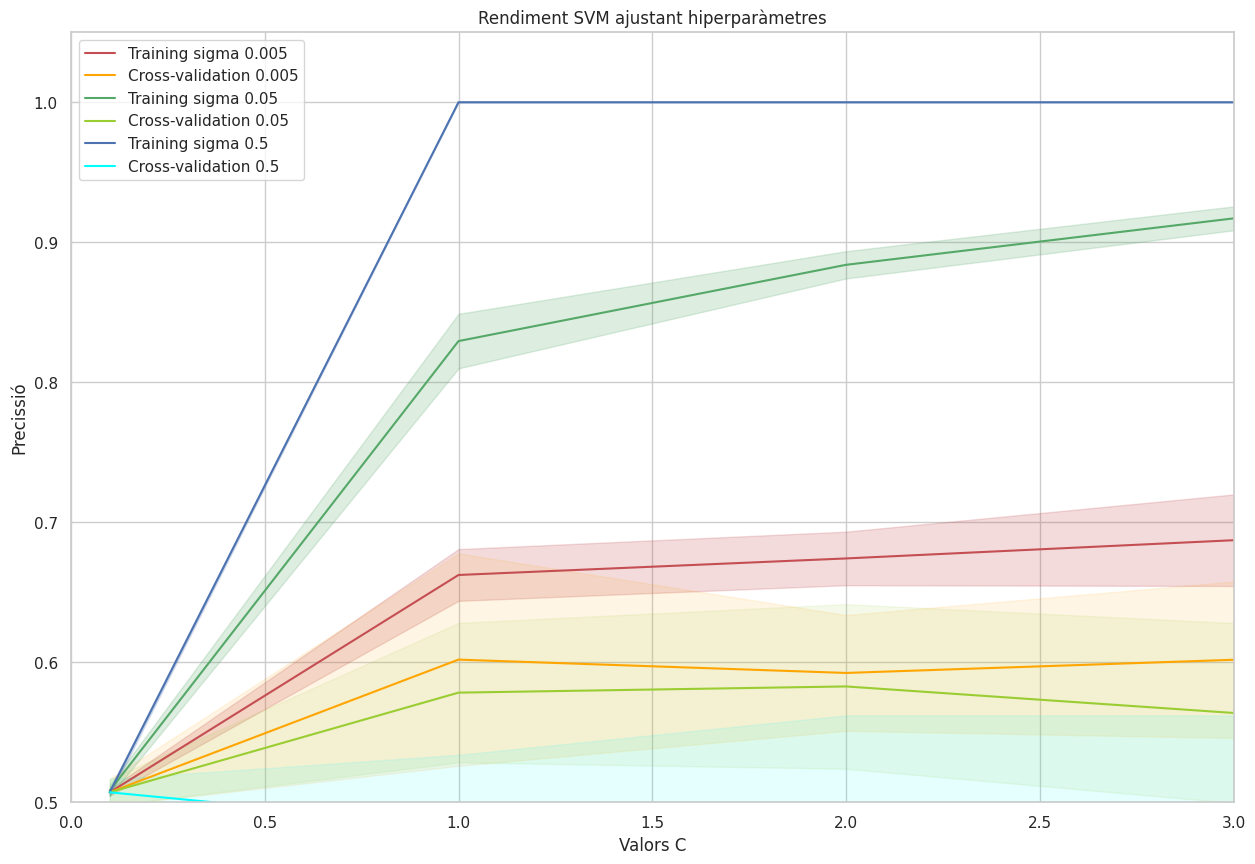

In [55]:
from sklearn.model_selection import validation_curve
C_range = [0.1, 1, 2,3]
#gamma_range = [0.0005,0.005, 0.05, 0.5]
gamma_range = [0.005, 0.05, 0.5]

colors_train = ['r','g','b','m']
colors_valid = ['orange','yellowgreen','aqua','y']

t_scores_Mean = []
v_scores_Mean = []
models = []
SVM_prediccions = []

plt.figure(figsize=(15,10))
plt.title("Rendiment SVM ajustant hiperparàmetres")
plt.xlabel("Valors C")
plt.ylabel("Precissió")
plt.ylim(0.5, 1.05)
plt.xlim(0.0, 3)

i = 0
for g in gamma_range:
    # calcular curva de validació amb els diferents valors de hiperparàmetres
    train_scores, valid_scores = validation_curve(
        SVC(kernel="rbf",random_state=seed, gamma = g), xtrain, ytrain, param_name="C", param_range=C_range,)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)


    # gràfic
    plt.plot(C_range, train_scores_mean, label="Training sigma " + str(gamma_range[i]), color=colors_train[i])
    plt.fill_between(C_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2, color=colors_train[i])
    plt.plot(C_range, valid_scores_mean, label="Cross-validation "+ str(gamma_range[i]),
                color=colors_valid[i])
    plt.fill_between(C_range, valid_scores_mean - valid_scores_std,
                    valid_scores_mean + valid_scores_std, alpha=0.1, color=colors_valid[i])

    # guardar els resultats
    sigma="RBF sigma "+ str(gamma_range[i])
    for c in C_range:
        models.append(sigma + " C "+ str(c))
    t_scores_Mean.append(train_scores_mean)
    v_scores_Mean.append(valid_scores_mean)

    i += 1

plt.legend(loc="best")
plt.show()

In [56]:
print(models)
print(t_scores_Mean)
print(v_scores_Mean)

['RBF sigma 0.005 C 0.1', 'RBF sigma 0.005 C 1', 'RBF sigma 0.005 C 2', 'RBF sigma 0.005 C 3', 'RBF sigma 0.05 C 0.1', 'RBF sigma 0.05 C 1', 'RBF sigma 0.05 C 2', 'RBF sigma 0.05 C 3', 'RBF sigma 0.5 C 0.1', 'RBF sigma 0.5 C 1', 'RBF sigma 0.5 C 2', 'RBF sigma 0.5 C 3']
[array([0.50710764, 0.66233446, 0.67414765, 0.6871654 ]), array([0.50829107, 0.8293956 , 0.88387574, 0.91704706]), array([0.50710764, 1.        , 1.        , 1.        ])]
[array([0.50708749, 0.60188261, 0.5923588 , 0.60177187]), array([0.50708749, 0.57829457, 0.58272425, 0.56378738]), array([0.50708749, 0.48316722, 0.49734219, 0.49734219])]


el millor RBF sigma 0.05 C 2

In [57]:
#inicialització del classificador
model_SVM_RBF_C_Sigma = SVC(kernel='rbf',random_state=seed,gamma=0.05,C=2.3)
# entrenar
model_SVM_RBF_C_Sigma.fit(xtrain,ytrain)
# predicció
pred_SVM_RBF_C_Sigma = model_SVM_RBF_C_Sigma.predict(xtest)

Text(29.999999999999993, 0.5, 'Predit')

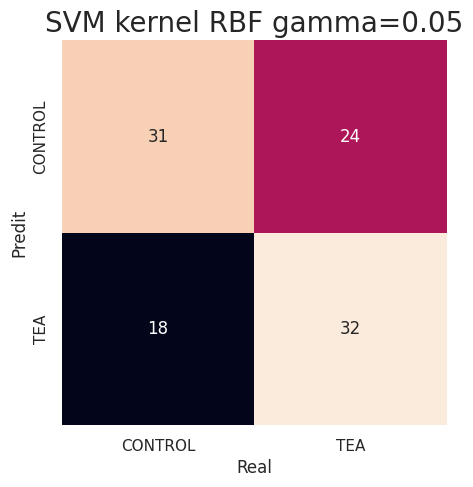

In [58]:
# Plot Confusion Matrix
mat_SVM_RBF_C_Sigma = confusion_matrix(pred_SVM_RBF_C_Sigma, ytest)
names_SVM_RBF_C_Sigma = np.unique(pred_SVM_RBF_C_Sigma)
plt.figure(figsize=(5, 5))
plt.title("SVM kernel RBF gamma=0.05",fontsize=20)
sns.heatmap(mat_SVM_RBF_C_Sigma, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_SVM_RBF_C_Sigma, yticklabels=names_SVM_RBF_C_Sigma)
plt.xlabel('Real')
plt.ylabel('Predit')

In [59]:
report_SVM_RBF_C_Sigma = classification_report(ytest, pred_SVM_RBF_C_Sigma)
print(report_SVM_RBF_C_Sigma)

              precision    recall  f1-score   support

     CONTROL       0.56      0.63      0.60        49
         TEA       0.64      0.57      0.60        56

    accuracy                           0.60       105
   macro avg       0.60      0.60      0.60       105
weighted avg       0.60      0.60      0.60       105



# Arbre de classificació

### Arbre de classificació amb els valors per defecte (sense boosting):

In [60]:
#inicialització del classificador
model_DC = DecisionTreeClassifier()
# entrenar
model_DC.fit(xtrain,ytrain)
# predicció
pred_DC = model_DC.predict(xtest)

Text(29.999999999999993, 0.5, 'Predit')

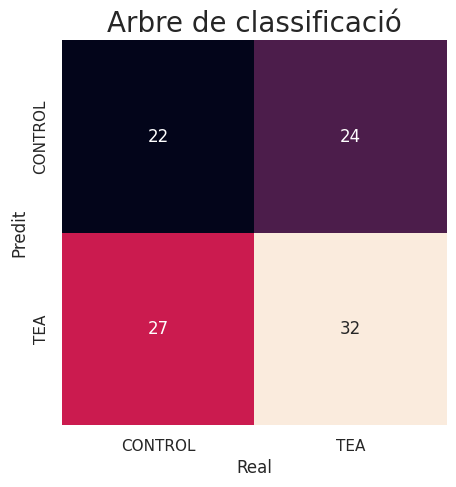

In [61]:
# Plot Confusion Matrix
mat_DC = confusion_matrix(pred_DC, ytest)
names_DC = np.unique(pred_DC)
plt.figure(figsize=(5, 5))
plt.title("Arbre de classificació",fontsize=20)
sns.heatmap(mat_DC, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_DC, yticklabels=names_DC)
plt.xlabel('Real')
plt.ylabel('Predit')

In [62]:
report_DC = classification_report(ytest, pred_DC)
print(report_DC)

              precision    recall  f1-score   support

     CONTROL       0.48      0.45      0.46        49
         TEA       0.54      0.57      0.56        56

    accuracy                           0.51       105
   macro avg       0.51      0.51      0.51       105
weighted avg       0.51      0.51      0.51       105



### Arbre de classificació activant boosting:

Aquest algoritme s'alpica sobre els resultats de l'arbre de classificació (*weak learner*)per millorar els resultats

In [63]:
from sklearn.ensemble import AdaBoostClassifier
#inicialització del classificador
model_Boosting = AdaBoostClassifier(estimator = model_DC)
# entrenar
model_Boosting.fit(xtrain,ytrain)
# predicció
pred_Boosting = model_Boosting.predict(xtest)

Text(29.999999999999993, 0.5, 'Predit')

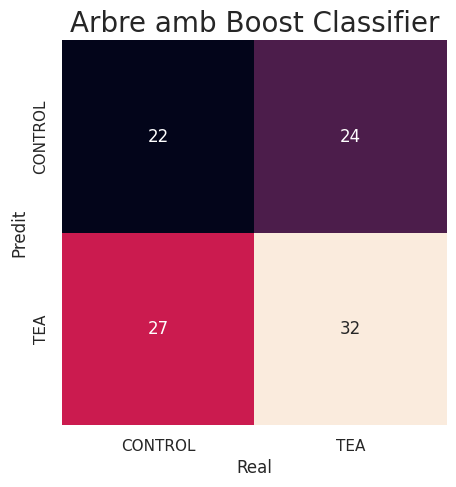

In [64]:
# Plot Confusion Matrix
mat_Boosting= confusion_matrix(pred_Boosting, ytest)
names_Boosting = np.unique(pred_Boosting)
plt.figure(figsize=(5, 5))
plt.title("Arbre amb Boost Classifier",fontsize=20)
sns.heatmap(mat_Boosting, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_Boosting, yticklabels=names_Boosting)
plt.xlabel('Real')
plt.ylabel('Predit')

In [65]:
report_Boosting = classification_report(ytest, pred_Boosting)
print(report_Boosting)

              precision    recall  f1-score   support

     CONTROL       0.48      0.45      0.46        49
         TEA       0.54      0.57      0.56        56

    accuracy                           0.51       105
   macro avg       0.51      0.51      0.51       105
weighted avg       0.51      0.51      0.51       105



### Arbre de classificació amb gradient boosting:

In [66]:
#inicialització del classificador
model_GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1,random_state=0)
# entrenar
model_GBC.fit(xtrain,ytrain)
# predicció
pred_GBC = model_GBC.predict(xtest)

Text(29.999999999999993, 0.5, 'Predit')

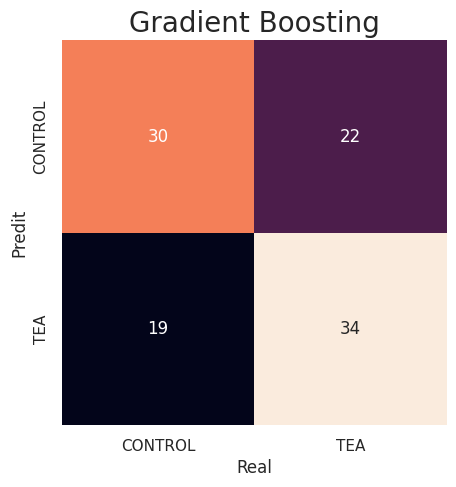

In [67]:
# Plot Confusion Matrix
mat_GBC= confusion_matrix(pred_GBC, ytest)
names_GBC = np.unique(pred_GBC)
plt.figure(figsize=(5, 5))
plt.title("Gradient Boosting",fontsize=20)
sns.heatmap(mat_GBC, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_GBC, yticklabels=names_GBC)
plt.xlabel('Real')
plt.ylabel('Predit')

In [68]:
report_GBC = classification_report(ytest, pred_GBC)
print(report_GBC)

              precision    recall  f1-score   support

     CONTROL       0.58      0.61      0.59        49
         TEA       0.64      0.61      0.62        56

    accuracy                           0.61       105
   macro avg       0.61      0.61      0.61       105
weighted avg       0.61      0.61      0.61       105



## Random Forest

En aquest cas hi haurà dues versions:

1- Amb 100 arbres

2- Amb 200 arbres

### Random Forest amb *n*=100

In [69]:
n=100
#inicialització del classificador
model_RF_100 = RandomForestClassifier(n_estimators=n)
# entrenar
model_RF_100.fit(xtrain,ytrain)
# predicció
pred_RF_100 = model_RF_100.predict(xtest)

Text(29.999999999999993, 0.5, 'Predit')

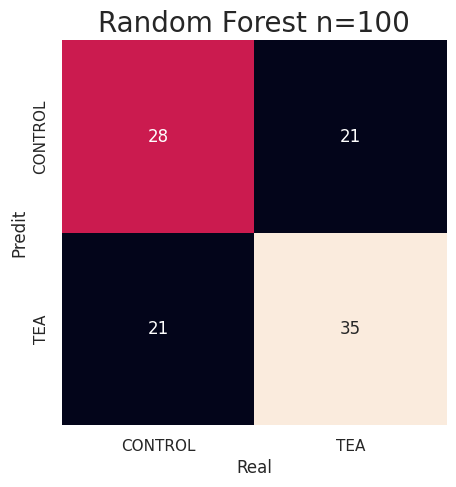

In [70]:
# Plot Confusion Matrix
mat_RF_100= confusion_matrix(pred_RF_100, ytest)
names_RF_100 = np.unique(pred_RF_100)
plt.figure(figsize=(5, 5))
plt.title("Random Forest n=100",fontsize=20)
sns.heatmap(mat_RF_100, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_RF_100, yticklabels=names_RF_100)
plt.xlabel('Real')
plt.ylabel('Predit')

In [71]:
report_RF_100 = classification_report(ytest, pred_RF_100)
print(report_RF_100)

              precision    recall  f1-score   support

     CONTROL       0.57      0.57      0.57        49
         TEA       0.62      0.62      0.62        56

    accuracy                           0.60       105
   macro avg       0.60      0.60      0.60       105
weighted avg       0.60      0.60      0.60       105



### Random Forest amb *n*=200

In [72]:
n=200
#inicialització del classificador
model_RF_200 = RandomForestClassifier(n_estimators=n)
# entrenar
model_RF_200.fit(xtrain,ytrain)
# predicció
pred_RF_200 = model_RF_200.predict(xtest)

Text(29.999999999999993, 0.5, 'Predit')

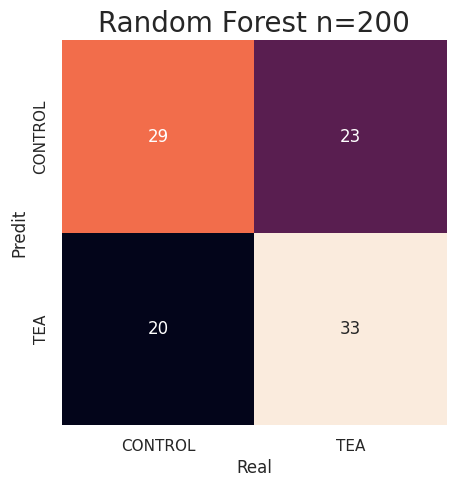

In [73]:
# Plot Confusion Matrix
mat_RF_200= confusion_matrix(pred_RF_200, ytest)
names_RF_200 = np.unique(pred_RF_200)
plt.figure(figsize=(5, 5))
plt.title("Random Forest n=200",fontsize=20)
sns.heatmap(mat_RF_200, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_RF_200, yticklabels=names_RF_200)
plt.xlabel('Real')
plt.ylabel('Predit')

In [74]:
report_RF_200 = classification_report(ytest, pred_RF_200)
print(report_RF_200)


              precision    recall  f1-score   support

     CONTROL       0.56      0.59      0.57        49
         TEA       0.62      0.59      0.61        56

    accuracy                           0.59       105
   macro avg       0.59      0.59      0.59       105
weighted avg       0.59      0.59      0.59       105



# XGBoost

In [75]:
#inicialització del classificador
# valors per defecte
# n_estimators = 100 -> nombre d'arbres
# max_depth = 6 -> profunditat màxima dels arbres
# learning_rate=0.3 -> taxa d'aprenentatge
# subsample = 1.0 -> Fracció de mostres utilitzades per cada arbre
# colsample_bytree = 1.0 -> Fracció de característiques utilitzades en cada arbre
# gamma = 0 -> mínima reducció de pèrdua necessària per fer una particició
model_XGB = xgb.XGBClassifier(random_state=42)
# entrenar
model_XGB.fit(x_tensor_train, y_tensor_train)

# predicció
pred_XGB = model_XGB.predict(x_tensor_test)

Text(30.0, 0.5, 'Predit')

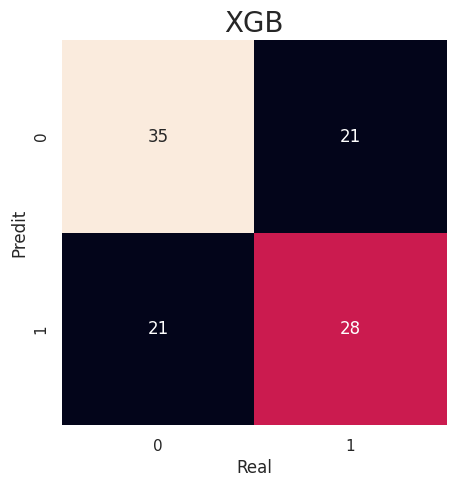

In [76]:
# Plot Confusion Matrix
mat_XGB= confusion_matrix(pred_XGB, y_tensor_test)
names_XGB = np.unique(pred_XGB)
plt.figure(figsize=(5, 5))
plt.title("XGB",fontsize=20)
sns.heatmap(mat_XGB, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_XGB, yticklabels=names_XGB)
plt.xlabel('Real')
plt.ylabel('Predit')

In [77]:
report_XGB = classification_report(y_tensor_test, pred_XGB)
print(report_XGB)

              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62        56
         1.0       0.57      0.57      0.57        49

    accuracy                           0.60       105
   macro avg       0.60      0.60      0.60       105
weighted avg       0.60      0.60      0.60       105



# CATBoost

In [78]:
cat_model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='Accuracy',
    verbose=100
)

# Entrenament
cat_model.fit(xtrain, ytrain, eval_set=(xtest, ytest))

# Prediccions
y_pred_CAT = cat_model.predict(xtest)

0:	learn: 0.7014218	test: 0.6000000	best: 0.6000000 (0)	total: 52.3ms	remaining: 52.2s
100:	learn: 1.0000000	test: 0.6380952	best: 0.6476190 (78)	total: 440ms	remaining: 3.92s
200:	learn: 1.0000000	test: 0.6571429	best: 0.6761905 (121)	total: 816ms	remaining: 3.24s
300:	learn: 1.0000000	test: 0.6476190	best: 0.6761905 (121)	total: 1.22s	remaining: 2.84s
400:	learn: 1.0000000	test: 0.6476190	best: 0.6761905 (121)	total: 1.6s	remaining: 2.39s
500:	learn: 1.0000000	test: 0.6476190	best: 0.6761905 (121)	total: 2.01s	remaining: 2s
600:	learn: 1.0000000	test: 0.6476190	best: 0.6761905 (121)	total: 2.38s	remaining: 1.58s
700:	learn: 1.0000000	test: 0.6476190	best: 0.6761905 (121)	total: 2.77s	remaining: 1.18s
800:	learn: 1.0000000	test: 0.6571429	best: 0.6761905 (121)	total: 3.18s	remaining: 789ms
900:	learn: 1.0000000	test: 0.6666667	best: 0.6761905 (121)	total: 3.56s	remaining: 391ms
999:	learn: 1.0000000	test: 0.6666667	best: 0.6761905 (121)	total: 3.97s	remaining: 0us

bestTest = 0.676190

Text(29.999999999999993, 0.5, 'Predit')

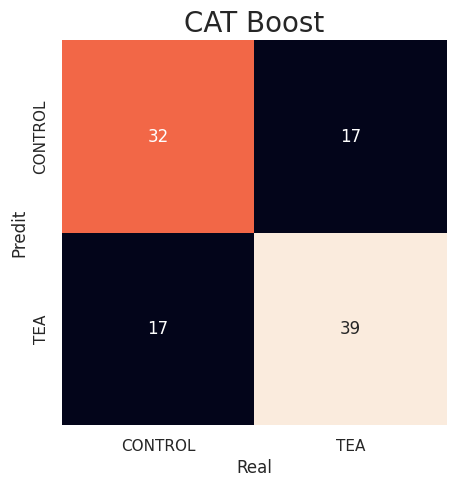

In [79]:
# Plot Confusion Matrix
mat_CATBoost= confusion_matrix(y_pred_CAT, ytest)
names_CATBoost = np.unique(y_pred_CAT)
plt.figure(figsize=(5, 5))
plt.title("CAT Boost",fontsize=20)
sns.heatmap(mat_CATBoost, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_CATBoost, yticklabels=names_CATBoost)
plt.xlabel('Real')
plt.ylabel('Predit')

In [80]:
report_CATBoost = classification_report(ytest, y_pred_CAT)
print(report_CATBoost)

              precision    recall  f1-score   support

     CONTROL       0.65      0.65      0.65        49
         TEA       0.70      0.70      0.70        56

    accuracy                           0.68       105
   macro avg       0.67      0.67      0.67       105
weighted avg       0.68      0.68      0.68       105



# Resum rendiments

In [81]:
noms = ["kNN 1","kNN 3","kNN 5","kNN 7","kNN 11","Naive Bayes",
        "NN 1 Hidden Layer","NN 2 Hidden Layer", "SVM Kernel Lineal",
        "SVM Kernel RBF", "SVM Kernel RBF sigma= 0.05 C=2.3",
        "Arbre Classificació","Arbre Classificació Boosting (Ada)",
        "Arbre Classificació Boosting (Gradient)", "Random Forest 100",
        "Random Forest 200","XGB","CATBoost"]
predictions = prediccions_KNN + [pred_NaiveBayes,tf.round(preds_NN_1_H_Layer),
                                 tf.round(preds_NN_2_H_Layer),pred_SVM_Lineal,
                                 pred_SVM_RBF,pred_SVM_RBF_C_Sigma,
                                 pred_DC, pred_Boosting,
                                 pred_GBC,pred_RF_100,pred_RF_200,
                                 tf.round(pred_XGB),y_pred_CAT]

macro_avg_f1 = []
macro_weighted_f1 = []

accuracy = []
TEA = []
CONTROL = []


i = 0
for p in predictions:
    # Generate classification report
    if ("Hidden Layer" in noms[i] or noms[i]  == "XGB"):
        class_report = classification_report(y_tensor_test, p, output_dict=True)
        TEA.append(class_report['0.0']['f1-score'])
        CONTROL.append(class_report['1.0']['f1-score'])
    else:
        class_report = classification_report(ytest, p, output_dict=True)
        TEA.append(class_report['TEA']['f1-score'])
        CONTROL.append(class_report['CONTROL']['f1-score'])


    # Append to list
    macro_avg_f1.append(class_report['macro avg']['f1-score'] )
    macro_weighted_f1.append(class_report['weighted avg']['f1-score'] )

    accuracy.append(class_report['accuracy'])


    i += 1

metriques = {'Models':noms, 'Precisió':accuracy, 'f1 TEA':TEA,
             'f1 Control':CONTROL,
             'Precisió avg':macro_avg_f1,
             'Precisió weighted':macro_weighted_f1}

df_metriques = pd.DataFrame(metriques)

#taula resum
display(df_metriques)

,Models,Precisió,f1 TEA,f1 Control,Precisió avg,Precisió weighted
0,kNN 1,0.533333,0.524272,0.542056,0.533164,0.532571
1,kNN 3,0.571429,0.545455,0.594595,0.570025,0.568387
2,kNN 5,0.561905,0.530612,0.589286,0.559949,0.557993
3,kNN 7,0.542857,0.489362,0.586207,0.537784,0.534556
4,kNN 11,0.590476,0.527473,0.638655,0.583064,0.579358
5,Naive Bayes,0.561905,0.530612,0.589286,0.559949,0.557993
6,NN 1 Hidden Layer,0.523810,0.519231,0.528302,0.523766,0.523464
7,NN 2 Hidden Layer,0.590476,0.537634,0.632479,0.585057,0.581895
8,SVM Kernel Lineal,0.504762,0.527273,0.480000,0.503636,0.505212
9,SVM Kernel RBF,0.600000,0.588235,0.611111,0.599673,0.598911


El millor rendiment s'obté amb CatBoost